In [197]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import cartopy

import neural_lam.config as nlc

# DANRA

In [96]:
danra_interior_config = "/home/joel/repos/neural-lam/configs/danra_example_model1/danra_model1_config.yaml"
danra_boundary_config = "/home/joel/repos/neural-lam/configs/danra_example_model1/era_model1_config.yaml"

In [102]:
danra_interior_ds = nlc.init_datastore("mdp", danra_interior_config)
danra_boundary_ds = nlc.init_datastore("mdp", danra_boundary_config)

2025-02-24 16:54:17.282 | WARNING  | neural_lam.datastore.mdp:__init__:67 - Config file has been modified since zarr was created. The old zarr archive (in /home/joel/repos/neural-lam/configs/danra_example_model1/danra_model1_config.zarr) will be used.To generate new zarr-archive, move the old one first.
2025-02-24 16:54:17.395 | WARNING  | neural_lam.datastore.mdp:__init__:67 - Config file has been modified since zarr was created. The old zarr archive (in /home/joel/repos/neural-lam/configs/danra_example_model1/era_model1_config.zarr) will be used.To generate new zarr-archive, move the old one first.
/home/joel/repos/neural-lam/neural_lam/datastore/mdp.py:200: UserWarning: no state data found in datastore
  warnings.warn(f"no {category} data found in datastore")


The loaded datastore contains the following features:
 state   : pres_seasurface t2m u10m v10m pres0m lwavr0m swavr0m z100 z200 z400 z600 z700 z850 z925 z1000 t100 t200 t400 t600 t700 t850 t925 t1000 r100 r200 r400 r600 r700 r850 r925 r1000 u100 u200 u400 u600 u700 u850 u925 u1000 v100 v200 v400 v600 v700 v850 v925 v1000 tw100 tw200 tw400 tw600 tw700 tw850 tw925 tw1000
 forcing : toa_radiation hour_of_day_sin hour_of_day_cos day_of_year_sin day_of_year_cos
 static  : lsm orography
With the following splits (over time):
 train   : 2000-01-01T00:00 to 2000-01-07T00:00
 val     : 2000-01-01T00:00 to 2000-01-07T00:00
 test    : 2000-01-01T00:00 to 2000-01-07T00:00
The loaded datastore contains the following features:
 forcing : mean_sea_level_pressure 2m_temperature 10m_u_component_of_wind 10m_v_component_of_wind surface_pressure toa_radiation hour_of_day_sin hour_of_day_cos day_of_year_sin day_of_year_cos geopotential100 geopotential200 geopotential400 geopotential600 geopotential700 geop

In [103]:
danra_boundary_ds.get_lat_lon("forcing")

array([[  0.  ,  70.  ],
       [  0.  ,  69.75],
       [  0.  ,  69.5 ],
       ...,
       [359.75,  41.25],
       [359.75,  41.  ],
       [359.75,  40.75]], dtype=float32)

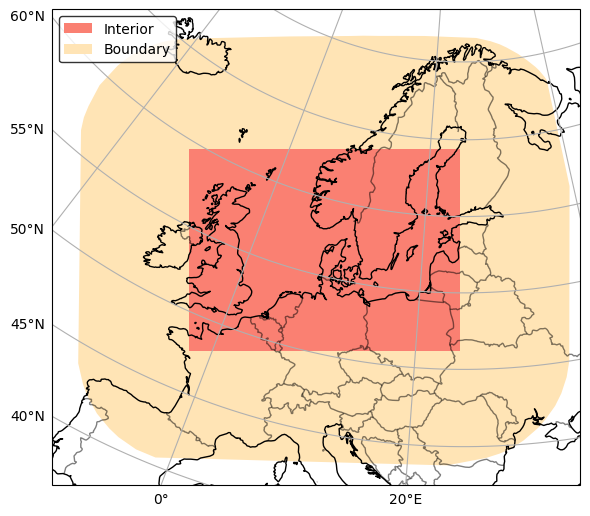

In [203]:
def plot_lam_setup(interior_ds, boundary_ds, lat_lon_extent):
    interior_color = "salmon"
    boundary_color = "moccasin"
    alpha = 1
    
    interior_xy = interior_ds.get_xy("state")
    x_min, y_min = interior_xy.min(axis=0)
    x_max, y_max = interior_xy.max(axis=0)
    
    # Create figure and axis with the projected CRS
    fig = plt.figure(figsize=(6, 6))
    
    global_crs = ccrs.PlateCarree()
    global_crs._threshold /= 100. # Fix a threshold to get round great circle arcs
    interior_crs = interior_ds.coords_projection
    ax = fig.add_subplot(1, 1, 1, projection=interior_crs)
    
    # Add some map features for context
    ax.coastlines()
    ax.gridlines(draw_labels=["left", "bottom"], x_inline=False, rotate_labels=False)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)

    # Add boundary
    # Note that we can work with euclidean tools here, as this is all latlon and PlateCarree
    boundary_points = boundary_ds.get_lat_lon("forcing").copy()
    boundary_points[boundary_points[:,0] > 180, 0] = -360 + boundary_points[boundary_points[:,0] > 180, 0]
    boundary_chull = ConvexHull(boundary_points)
    #ax.scatter(boundary_points[:,0], boundary_points[:,1], transform=global_crs)
    boundary_polygon_corners = np.stack([boundary_points[vertex] for vertex in boundary_chull.vertices], axis=0)
    boundary_chull_polygon = mpatches.Polygon(boundary_polygon_corners, 
        closed=True, transform=global_crs, facecolor=boundary_color, alpha=alpha)
    ax.add_patch(boundary_chull_polygon)

    # Add the interior    
    rect = mpatches.Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min),
        facecolor=interior_color, alpha=alpha, transform=interior_crs)
    ax.add_patch(rect)

    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor=interior_color, alpha=alpha, label='Interior'),
        mpatches.Patch(facecolor=boundary_color, alpha=alpha, label='Boundary'),
    ]
    ax.legend(handles=legend_elements, loc='upper left',
             frameon=True, facecolor="white", edgecolor="black", fontsize=10)
    
    # style and show/save
    ax.set_extent(lat_lon_extent, crs=ccrs.PlateCarree())
    fig.tight_layout()

    return fig

fig = plot_lam_setup(danra_interior_ds, danra_boundary_ds, [-12, 35, 42, 70])
fig.savefig("danra_region.pdf", format="pdf", bbox_inches="tight")

## COSMO

In [205]:
# TODO